In [404]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from scipy.stats.mstats import winsorize

In [405]:
# Dataset available at https://data.cityofnewyork.us/City-Government/Good-Food-Purchasing-Data/usrf-za7k
path = 'Good_Food_Purchasing_Data.csv'
df= pd.read_csv(path)

In [406]:
# Dropping rows with NaN values in any of the specified columns
df = df.dropna(subset=['# of Units', 'Total Weight in lbs', 'Total Cost'])
df[(df["Total Cost"].isna()) | (df["# of Units"].isna()) | (df["Total Weight in lbs"].isna())]

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost


In [407]:
# Set Total Cost and Total Weight in lbs to 0 where # of Units = 0
df.loc[df["# of Units"] == 0, ["Total Cost"]] = 0
df

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost
0,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 2 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,100.0,560.0
1,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 3 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,106.0,600.0
2,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, formula","Premium Nursette Ready-to-Feed Infant Formula,...",Enfamil,Babylab Inc.,Babylab Inc.,200.0,1200.0,16200.0
3,Administration for Childrens Services,2018-2019,Beverages,Beverages,"juice, fruit punch, ss","100% Juice Variety Pack, 4 fl oz bottles",Enfamil,Babylab Inc.,Babylab Inc.,100.0,600.0,1940.0
4,Administration for Childrens Services,2018-2019,Condiments & Snacks,Condiments & Snacks,"cereal, baby, oatmeal",Single Grain Oatmeal Baby Cereal,Enfamil,Babylab Inc.,Babylab Inc.,10.0,60.0,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17203,Department of Education,2020-2021,Produce,Vegetables,"vegetable, blend, frozen, commodity",Veg Mixed Vegetable No Salt Added Frzn USDA (VO),"NA, NA",NaN,NaN,9239.0,0.0,49463.0
17204,Department of Education,2020-2021,Seafood,Seafood,"fish, patty, breaded",Fish Breaded Patty,"NA, New Hampshire",NaN,NaN,7316.0,0.0,164246.0
17205,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",FoodCo,FoodCo,1978.0,49450.0,130101.0
17206,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",Teri Nichols,Teri Nichols,2903.0,72575.0,167341.0


In [418]:
df = df[df["Total Weight in lbs"] > 0]
df

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost
0,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 2 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,100.0,560.0
1,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 3 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,106.0,600.0
2,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, formula","Premium Nursette Ready-to-Feed Infant Formula,...",Enfamil,Babylab Inc.,Babylab Inc.,200.0,1200.0,16200.0
3,Administration for Childrens Services,2018-2019,Beverages,Beverages,"juice, fruit punch, ss","100% Juice Variety Pack, 4 fl oz bottles",Enfamil,Babylab Inc.,Babylab Inc.,100.0,600.0,1940.0
4,Administration for Childrens Services,2018-2019,Condiments & Snacks,Condiments & Snacks,"cereal, baby, oatmeal",Single Grain Oatmeal Baby Cereal,Enfamil,Babylab Inc.,Babylab Inc.,10.0,60.0,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17201,Department of Education,2020-2021,Produce,Vegetables,"vegetable cup, carrot, ranch, ss",Veg Carrots Ranch Ind (VRO),"Bolthouse, California",FoodCo,FoodCo,28660.0,335895.0,989362.0
17202,Department of Education,2020-2021,Produce,Vegetables,"vegetable cup, carrot, ranch, ss",Veg Carrots Ranch Ind (VRO),"Bolthouse, California",Teri Nichols,Teri Nichols,38643.0,452896.0,1333255.0
17205,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",FoodCo,FoodCo,1978.0,49450.0,130101.0
17206,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",Teri Nichols,Teri Nichols,2903.0,72575.0,167341.0


<Axes: xlabel='Total Cost'>

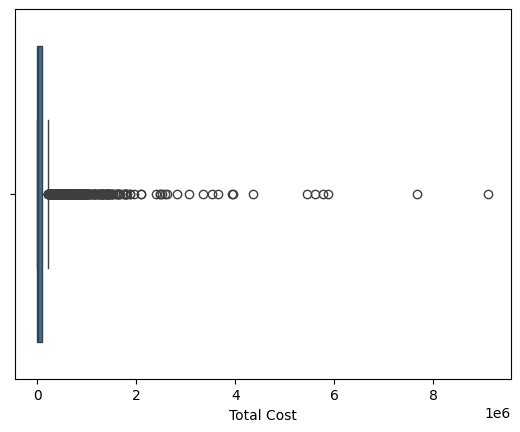

In [419]:
sns.boxplot(x=df["Total Cost"])

In [420]:
df["Total Cost"].mean()

134790.95532846716

In [421]:
# winsorize Total Cost column to get rid of outliers
df.loc[:, "Total Cost"] = winsorize(df["Total Cost"], limits=(None, 0.0005))

<Axes: xlabel='Total Cost'>

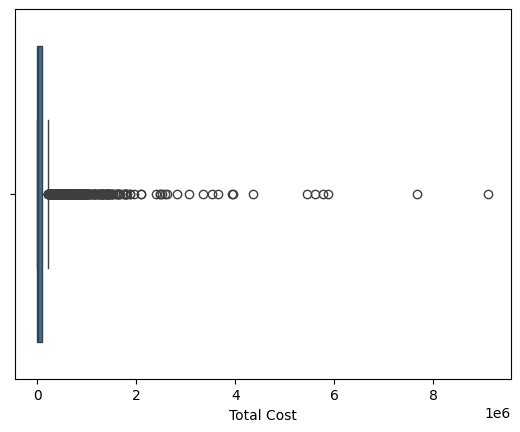

In [422]:
sns.boxplot(x=df["Total Cost"])

In [423]:
df["Total Cost"].mean()

134790.95532846716

In [424]:
filtered_df = df.iloc[:, 9:12]
categorical_df = df.iloc[:, 0:9]

categorical_df["Total Cost"] = df["Total Cost"]
categorical_df

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,Total Cost
0,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 2 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,560.0
1,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 3 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,600.0
2,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, formula","Premium Nursette Ready-to-Feed Infant Formula,...",Enfamil,Babylab Inc.,Babylab Inc.,16200.0
3,Administration for Childrens Services,2018-2019,Beverages,Beverages,"juice, fruit punch, ss","100% Juice Variety Pack, 4 fl oz bottles",Enfamil,Babylab Inc.,Babylab Inc.,1940.0
4,Administration for Childrens Services,2018-2019,Condiments & Snacks,Condiments & Snacks,"cereal, baby, oatmeal",Single Grain Oatmeal Baby Cereal,Enfamil,Babylab Inc.,Babylab Inc.,290.0
...,...,...,...,...,...,...,...,...,...,...
17201,Department of Education,2020-2021,Produce,Vegetables,"vegetable cup, carrot, ranch, ss",Veg Carrots Ranch Ind (VRO),"Bolthouse, California",FoodCo,FoodCo,989362.0
17202,Department of Education,2020-2021,Produce,Vegetables,"vegetable cup, carrot, ranch, ss",Veg Carrots Ranch Ind (VRO),"Bolthouse, California",Teri Nichols,Teri Nichols,1333255.0
17205,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",FoodCo,FoodCo,130101.0
17206,Department of Education,2020-2021,Seafood,Seafood,"tuna, light, canned",Fish Tuna Light Can,"Golbon, NA",Teri Nichols,Teri Nichols,167341.0


In [425]:
# Step 2: Explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3425 entries, 0 to 17207
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Agency                 3425 non-null   object 
 1   Time Period            3425 non-null   object 
 2   Food Product Group     3425 non-null   object 
 3   Food Product Category  3425 non-null   object 
 4   Product Name           3424 non-null   object 
 5   Product Type           3425 non-null   object 
 6   Origin Detail          3300 non-null   object 
 7   Distributor            2679 non-null   object 
 8   Vendor                 3091 non-null   object 
 9   # of Units             3425 non-null   float64
 10  Total Weight in lbs    3425 non-null   float64
 11  Total Cost             3425 non-null   float64
dtypes: float64(3), object(9)
memory usage: 347.9+ KB


In [426]:
df.describe()

,# of Units,Total Weight in lbs,Total Cost
count,3.425000e+03,3.425000e+03,3.425000e+03
mean,8.789890e+04,1.236526e+05,1.347910e+05
std,1.335848e+06,7.086255e+05,4.233107e+05
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+02,7.330000e+02,1.183000e+03
50%,8.800000e+02,9.180000e+03,1.452300e+04
75%,4.968000e+03,6.743300e+04,8.938400e+04
max,5.050947e+07,2.525474e+07,9.110741e+06


<Axes: >

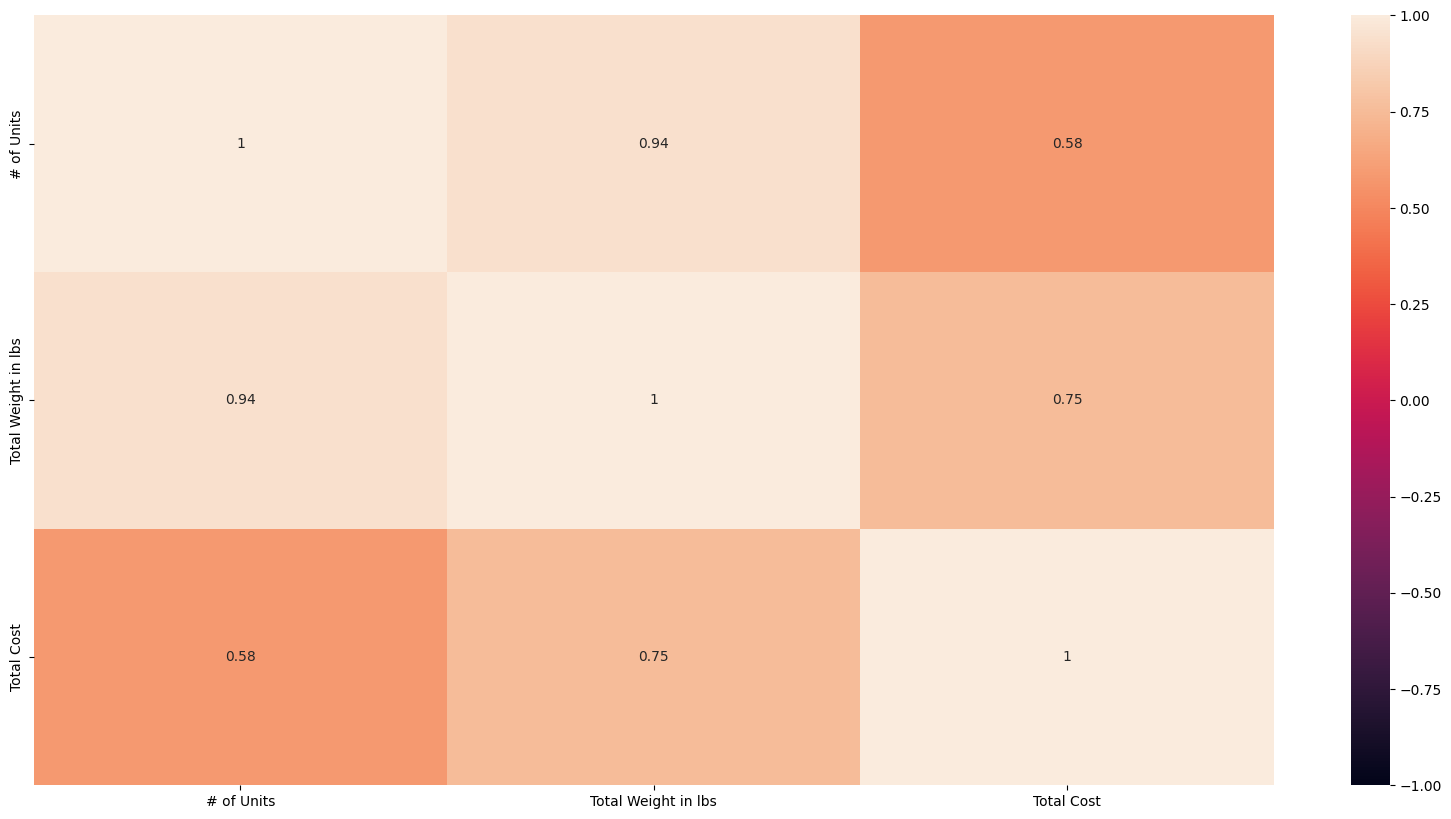

In [427]:
import matplotlib.colors as clr
# correlation matrix
myColors = ("red","white","blue")
cmap1 = clr.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
corr = filtered_df.corr()
mask = np.zeros_like(corr, dtype=bool)
#mask[np.triu_indices_from(mask)]= True
plt.figure(figsize=(20,10))
sns.heatmap(corr, mask = mask, vmin = -1, vmax = 1, annot=True)

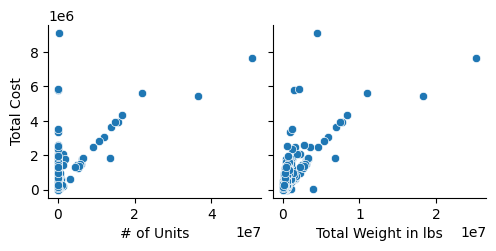

In [428]:
# Let Target be Total_cost
x_vars = ["# of Units", "Total Weight in lbs"]
y_vars = ["Total Cost"]
sns.pairplot(filtered_df, x_vars=x_vars, y_vars=y_vars)

<Axes: xlabel='Total Cost', ylabel='Food Product Category'>

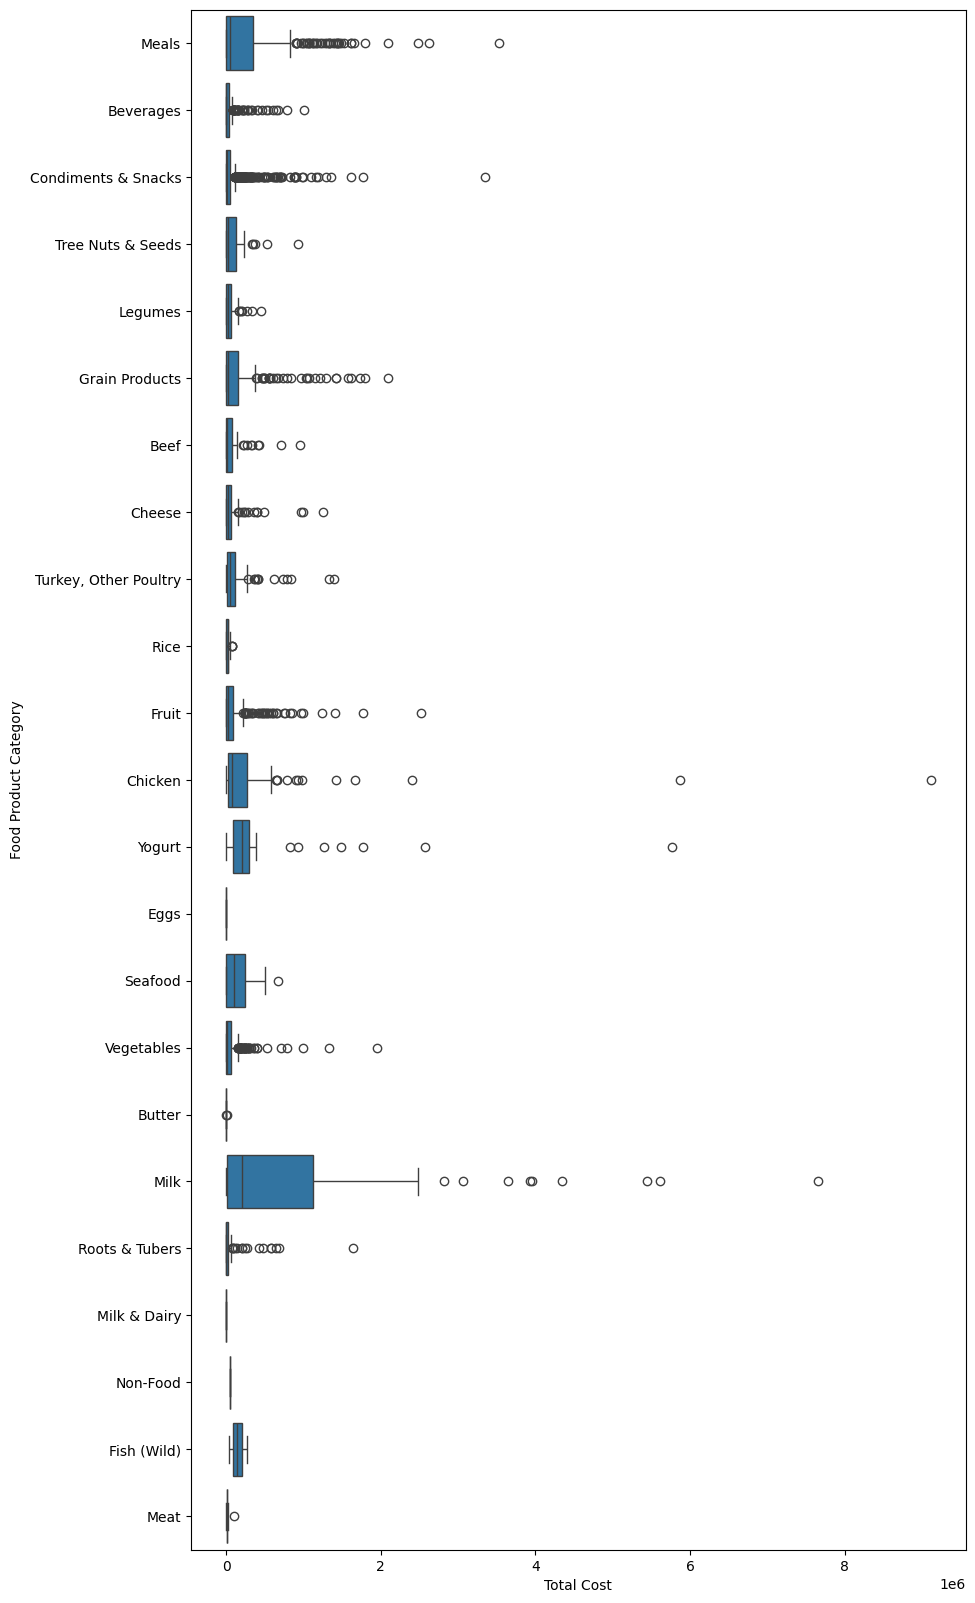

In [429]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Food Product Category", data=categorical_df)

<Axes: xlabel='Total Cost', ylabel='Vendor'>

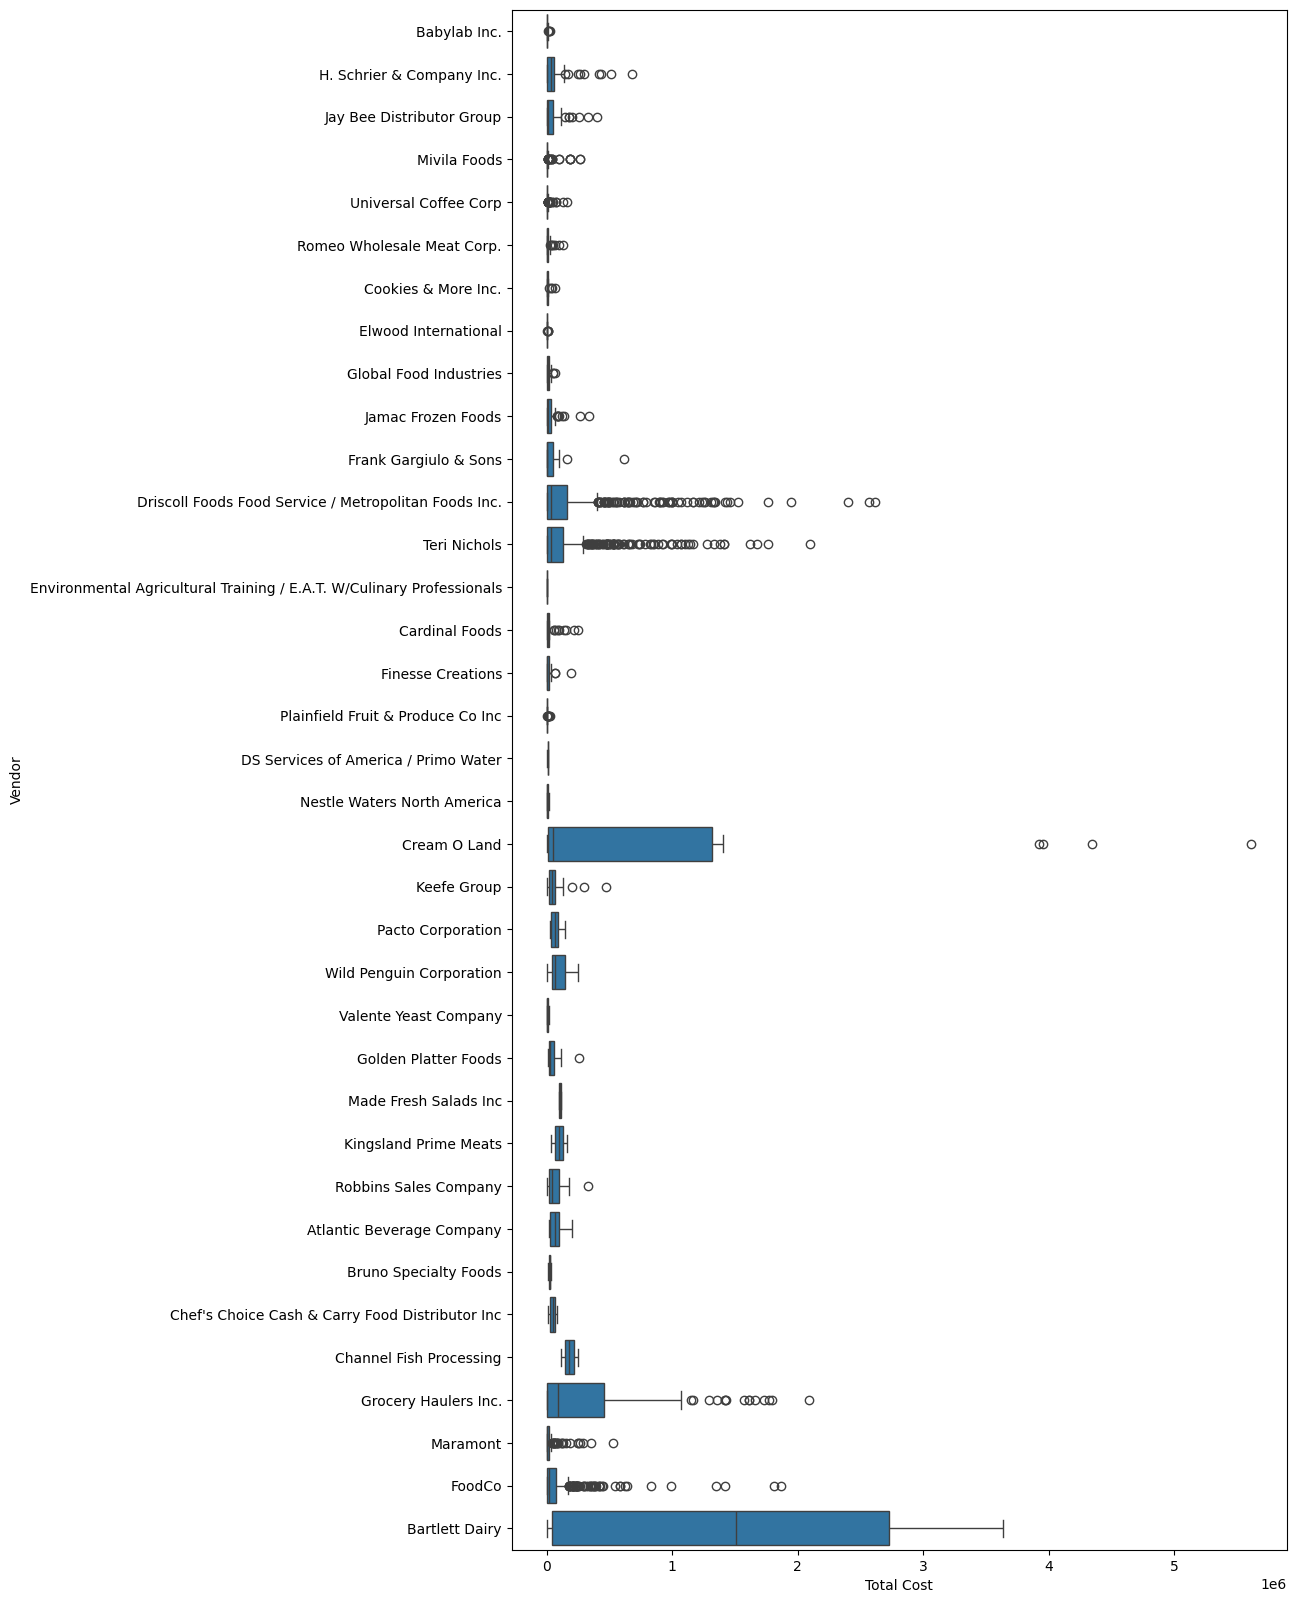

In [395]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot(x="Total Cost", y="Vendor", data=categorical_df)

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Time Period", data=categorical_df)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,600))  # Adjust the figure size as needed
sns.barplot(data=categorical_df, hue="Time Period", x="Total Cost", y="Product Name", orient="h")
plt.tight_layout()

<Axes: xlabel='Total Cost', ylabel='Food Product Group'>

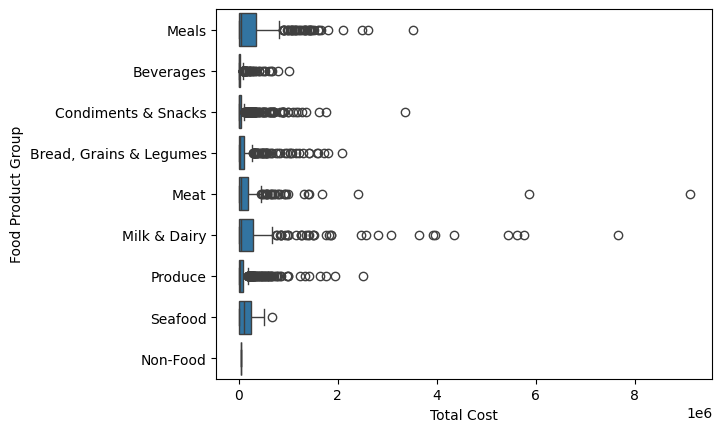

In [430]:
sns.boxplot( x="Total Cost", y="Food Product Group", data=categorical_df)

In [ ]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Distributor", data=categorical_df)
plt.tight_layout()  # Adjust layout for better visibility

In [ ]:
sns.boxplot( x="Total Cost", y="Agency", data=categorical_df)

In [431]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
categorical_cols = ['Food Product Category']
numeric_cols = ['# of Units', 'Total Weight in lbs']
X=df[['# of Units', 'Total Weight in lbs','Food Product Category']]
y=df['Total Cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=124)
X_train


,# of Units,Total Weight in lbs,Food Product Category
16023,18.0,360.0,Chicken
478,15.0,90.0,Meals
16428,2.0,36.0,Beverages
16308,464.0,464.0,Vegetables
16436,10598.0,268129.0,Beverages
...,...,...,...
4960,56.0,2408.0,Fruit
135,1.0,6.0,Condiments & Snacks
15550,1931.0,21724.0,Tree Nuts & Seeds
4661,3646.0,38283.0,Vegetables


In [432]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Splitting data into numerical and categorical DataFrames
X_train_categorical = X_train[categorical_cols]
X_train_numeric = X_train[numeric_cols]
X_test_categorical = X_test[categorical_cols]
X_test_numeric = X_test[numeric_cols]

# Pipeline for categorical data
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Pipeline for numerical data
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # or any desired strategy
])

# Fit and transform categorical data
X_train_categorical_enc = pd.DataFrame(categorical_pipe.fit_transform(X_train_categorical), columns=categorical_pipe['encoder'].get_feature_names_out(X_train_categorical.columns))
X_test_categorical_enc = pd.DataFrame(categorical_pipe.transform(X_test_categorical), columns=categorical_pipe['encoder'].get_feature_names_out(X_test_categorical.columns))

# Fit and transform numerical data
X_train_numeric_enc = pd.DataFrame(numeric_pipe.fit_transform(X_train_numeric), columns=X_train_numeric.columns)
X_test_numeric_enc = pd.DataFrame(numeric_pipe.transform(X_test_numeric), columns=X_test_numeric.columns)

# Display the transformed DataFrames
X_train_numeric_enc

c:\Users\rahul\OneDrive\Documents\Desktop\CS301_Project_1\myvenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,# of Units,Total Weight in lbs
0,18.0,360.0
1,15.0,90.0
2,2.0,36.0
3,464.0,464.0
4,10598.0,268129.0
...,...,...
2563,56.0,2408.0
2564,1.0,6.0
2565,1931.0,21724.0
2566,3646.0,38283.0


In [433]:
# Concatenating transformed categorical and numerical data
X_train_processed = pd.concat([X_train_numeric_enc, X_train_categorical_enc], axis=1)
X_test_processed = pd.concat([X_test_numeric_enc, X_test_categorical_enc], axis=1)

In [434]:
X_train_processed

,# of Units,Total Weight in lbs,Food Product Category_Beef,Food Product Category_Beverages,Food Product Category_Butter,Food Product Category_Cheese,Food Product Category_Chicken,Food Product Category_Condiments & Snacks,Food Product Category_Eggs,Food Product Category_Fish (Wild),...,Food Product Category_Milk,Food Product Category_Milk & Dairy,Food Product Category_Non-Food,Food Product Category_Rice,Food Product Category_Roots & Tubers,Food Product Category_Seafood,Food Product Category_Tree Nuts & Seeds,"Food Product Category_Turkey, Other Poultry",Food Product Category_Vegetables,Food Product Category_Yogurt
0,18.0,360.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,36.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,464.0,464.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,10598.0,268129.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,56.0,2408.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2564,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2565,1931.0,21724.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2566,3646.0,38283.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [435]:
X_test_processed

,# of Units,Total Weight in lbs,Food Product Category_Beef,Food Product Category_Beverages,Food Product Category_Butter,Food Product Category_Cheese,Food Product Category_Chicken,Food Product Category_Condiments & Snacks,Food Product Category_Eggs,Food Product Category_Fish (Wild),...,Food Product Category_Milk,Food Product Category_Milk & Dairy,Food Product Category_Non-Food,Food Product Category_Rice,Food Product Category_Roots & Tubers,Food Product Category_Seafood,Food Product Category_Tree Nuts & Seeds,"Food Product Category_Turkey, Other Poultry",Food Product Category_Vegetables,Food Product Category_Yogurt
0,400.0,400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1189.0,12485.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,329.0,329.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3205.0,26454.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,23.0,414.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
853,3106.0,93180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
854,200.0,200.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
855,26609.0,299351.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [436]:
# Fill NaN in y_train with the mean
y_train = y_train.fillna(y_train.mean())
# Step 5: Build a regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
model=lr.fit(X_train_processed,y_train)

In [437]:
# Fill NaN in y_test with the mean
y_test = y_test.fillna(y_test.mean())
# Evaluation Metric 1: R^2 score
from sklearn.metrics import r2_score
y_predicted = model.predict(X_test_processed)
r2_score(y_test, y_predicted)

0.7313281083840112

In [438]:
# Evaluation metric 2: MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_predicted)

27661918045.680107

In [364]:
# Make prediction for the new set of feature values (5, 15, 0, 0, 0, 1, 0, 0, 0, 0, 0)
# Prediciting the total cost of 5 units of Meals, weighing 15 lbs
model.predict(np.array([[5, 15, 0, 0, 0, 1, 0, 0, 0, 0, 0]]))

c:\Users\rahul\OneDrive\Documents\Desktop\CS301_Project_1\myvenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 11 features, but LinearRegression is expecting 25 features as input.